### sav info
https://www.nwcg.gov/term/glossary/surface-area-to-volume-ratio
The ratio between the surface area of an object, such as a fuel particle, to its volume. The smaller the particle, the more quickly it can become wet, dry out, or become heated to combustion temperature during a fire. 

https://en.wikipedia.org/wiki/Surface-area-to-volume_ratio#:~:text=In%20the%20context,fire%20spread%20rates.
In the context of wildfires, the ratio of the surface area of a solid fuel to its volume is an important measurement. Fire spread behavior is frequently correlated to the surface-area-to-volume ratio of the fuel (e.g. leaves and branches). The higher its value, the faster a particle responds to changes in environmental conditions, such as temperature or moisture. Higher values are also correlated to shorter fuel ignition times, and hence faster fire spread rates.

e.g. leaves, (thin materials), flat branches

### moisture info
https://www.ncdc.noaa.gov/monitoring-references/dyk/deadfuelmoisture

https://firesafesanmateo.org/resources/live-fuel-moisture

In [9]:
# install dependencies
!pip3 install fastfuels==0.5.3  s3fs==0.5.2 fsspec==0.8.3

In [5]:
import fastfuels
import matplotlib.pyplot as plt
import numpy as np

In [6]:
fio = fastfuels.open('https://wifire-data.sdsc.edu:9000/fastfuels/index.fio', ftype='s3', username='fastfuels', password='Treatment##Buffet')
fio.cache_limit = 1e14

### Sylvan Fire
- Sylvan Fire: https://inciweb.nwcg.gov/incident/7562/
- Location: Colorodo
- Date: June 20th - September 7th (90% containment)
- Cause: Lightning

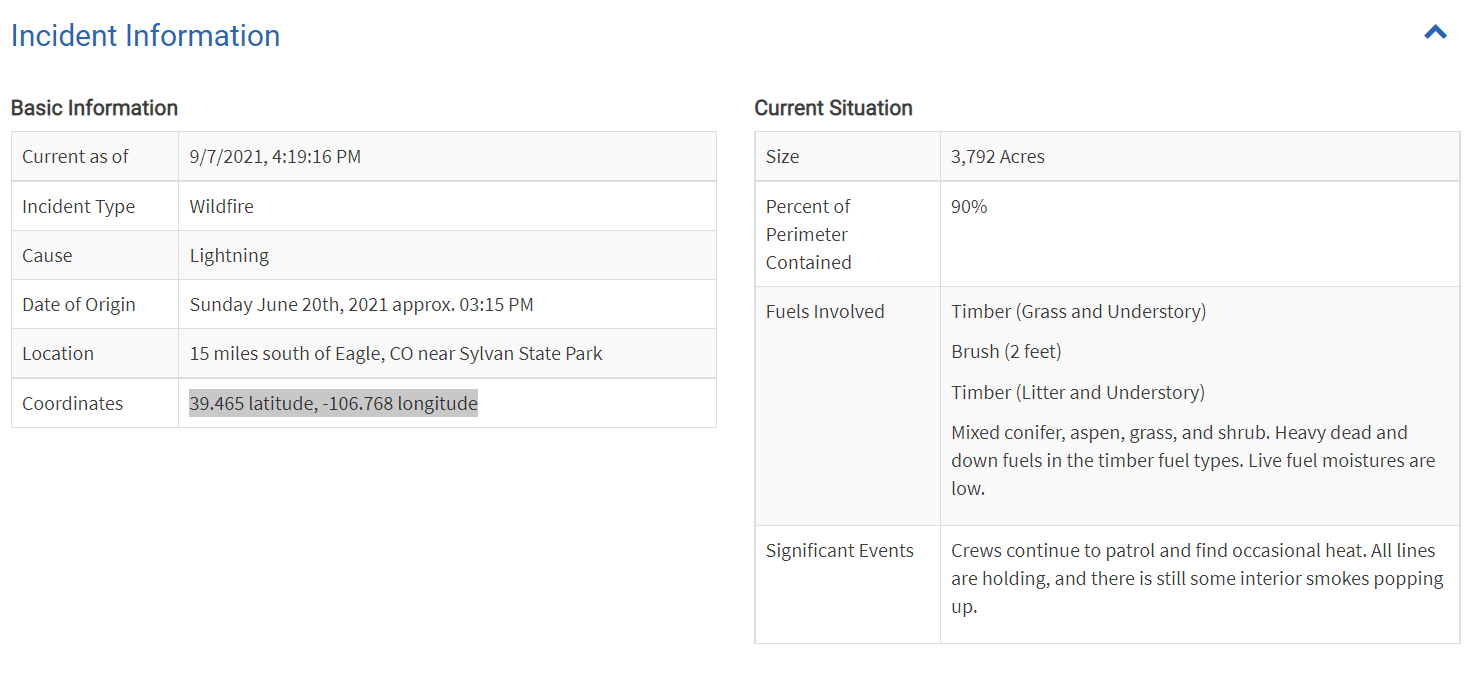

In [7]:
lat = 39.465
lon = -106.768
roi = fio.query(lon, lat, 500)

Bounding box query found in single source: co_set/co_101.fio


#### Observation
- Sylvan fire at specified coordinate has spread out dots of high sav (red) sorrounded by very low sav (blue) @ 500radius
- looks off compared to other sav maps
- which have gradients from red, orange, yellow in high sav areas or green, blue, purple such as in bodies of water
- is this map off? why are there high sav locations dispersed throughout the map?

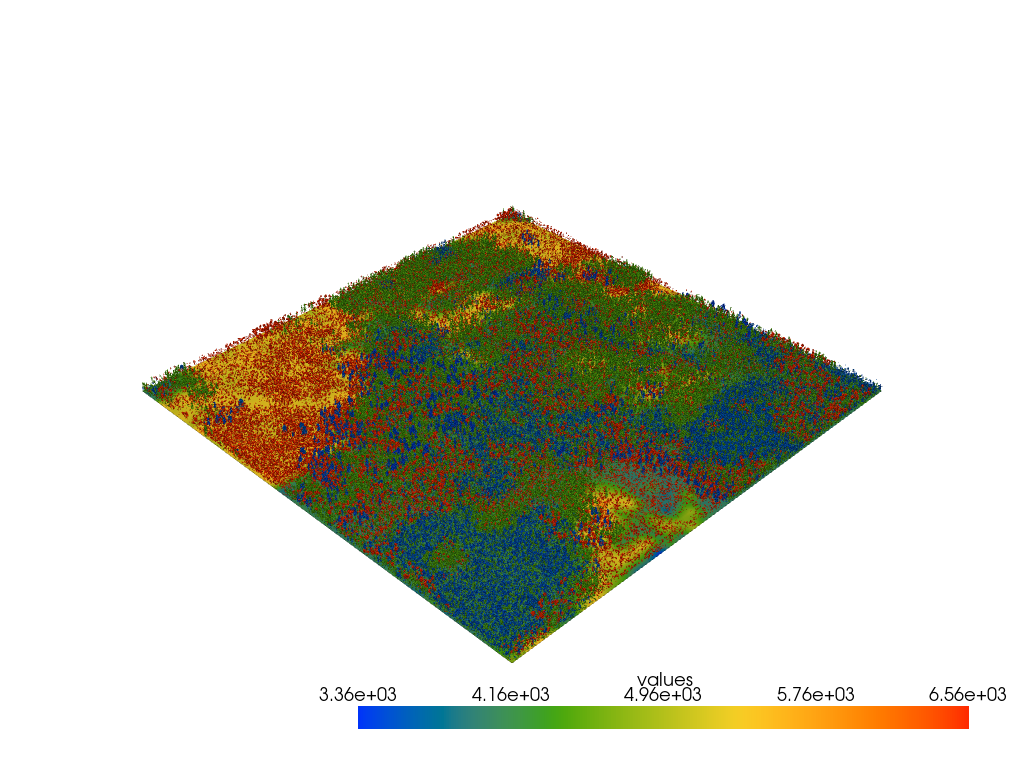

In [27]:
roi.view('sav')

#### Check with satellite image
- checked with same exact coordinate
- blue is maybe correllated with the low sav grass sorrounding the trees or the understory
- fuel/greenery looks fairly uniform in the google image so why is the sav not uniform
- maybe correct, maybe it is not uniform and it has different types of fuel that we can not see with this image

Google Maps Satellite view of coordinate
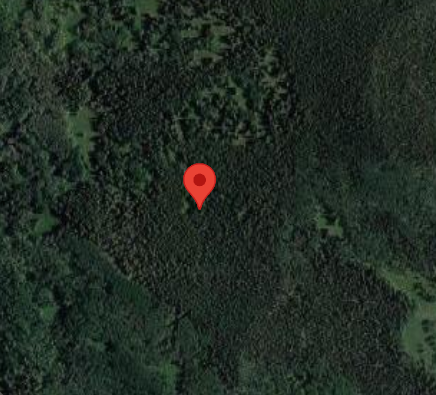

#### Testing different radiuses
- At (800m) dots become orange
- possible reasons: roi.view() takes an average/combination of voxels when displaying in limited view or artifacts
- tried 1000m killed kernel (stronger comp needed)

Bounding box query found in single source: co_set/co_101.fio


C:\Users\hirok\AppData\Local\Programs\Python\Python39\lib\site-packages\pyvista\core\dataset.py:1332: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(
C:\Users\hirok\AppData\Local\Programs\Python\Python39\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


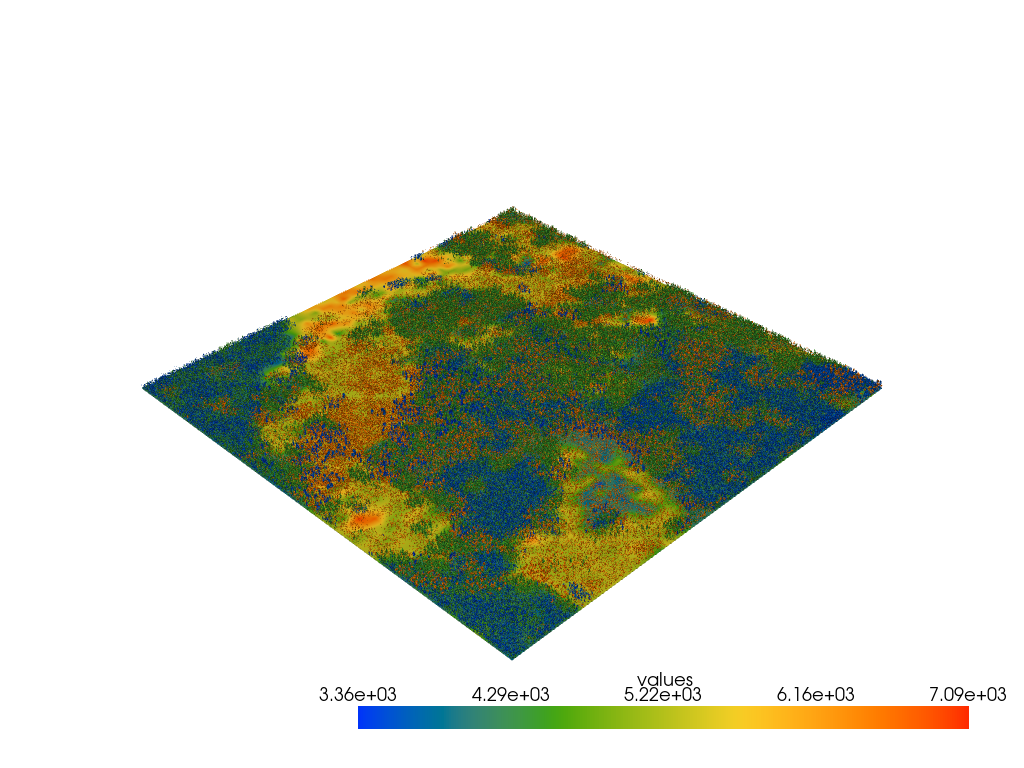

In [6]:
roi = fio.query(lon, lat, 800)
roi.view('sav')

#### 800m radius gives different map
- Sometiems when running some values through roi.view, some errors arise
- roi = fio.query(lon, lat+1, 0.5)
- roi.view('sav')
- ValueError: Empty meshes cannot be plotted. Input mesh has zero points.

- high sav near the bottom (maybe leaves), low sav near the top (maybe tree branch)
- had trouble with the "elevation" argument in the roi.view() function

### Voxel Views (SAV)
- High sav ratio seems to be clustered in single groups around low sav ratio figures
- High/low sav ratio clusters probably different types of fuel (different trees, understory, brush, etc)
- we can easily see these fuel formations with the query/view

Bounding box query found in single source: co_set/co_101.fio


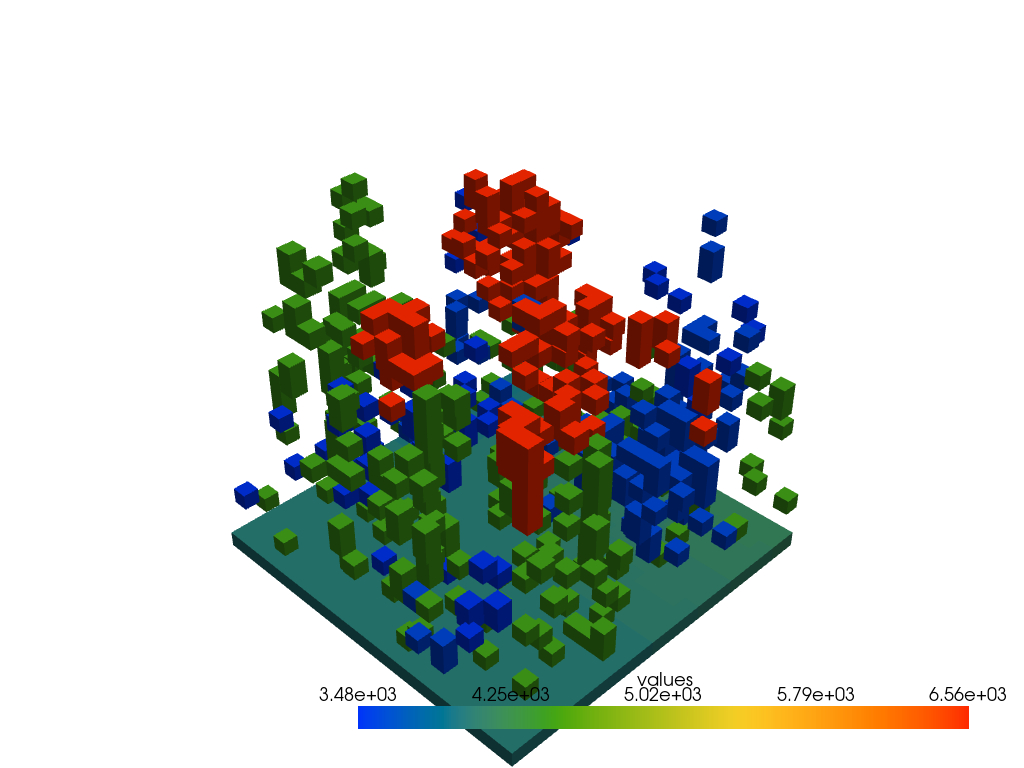

In [15]:
roi = fio.query(lon + 0.0001, lat, 12)
roi.view('sav')

Bounding box query found in single source: co_set/co_101.fio


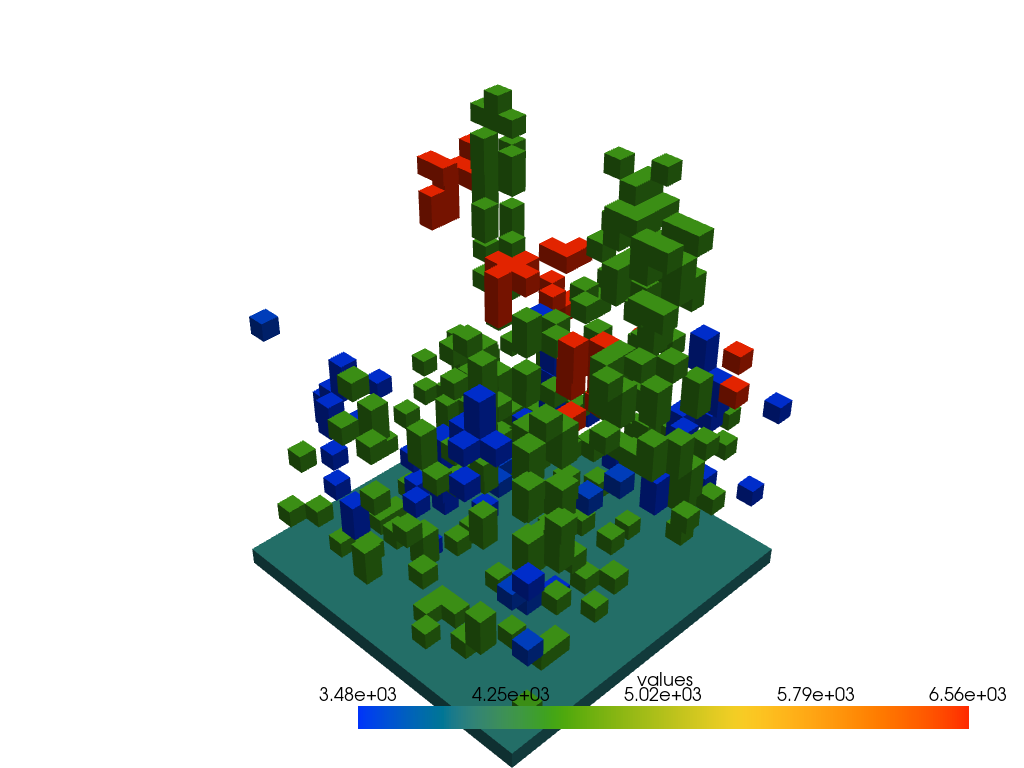

In [14]:
roi = fio.query(lon + 0.001, lat, 10)
roi.view('sav')

### Voxel Data
- air/zeros account for a lot of the data in the array, takes up a lot of space/memory
- zeros take up 98.5% of data for array; non-zero values take up 1.5%
- average with zeros is much higher than that without
- most fuel in this area has lower sav
- histogram confirms our initial observation that there is a lot of voxels with low sav and few areas with high sav that is disconnected from the rest of the area (i.e. there is no intermediary sav voxels between 4500 and 6500)

In [9]:
roi = fio.query(lon, lat, 3)
raw_sav_data = roi.data_dict['sav']

Bounding box query found in single source: co_set/co_101.fio


In [19]:
no_zeros = np.where(raw_sav_data!=0,raw_sav_data,np.nan)
print('sav stats')
print('min: ', np.nanmin(no_zeros))
print('max: ', np.max(raw_sav_data))
print('average with zeros: ', np.mean(raw_sav_data))
print('average without zeros: ', np.nanmean(no_zeros))

sav stats
min:  3482.353
max:  6556.863
average with zeros:  65.68567
average without zeros:  4328.3223


In [29]:
total_num = np.size(raw_sav_data)
print('nonzeros%: ', 100 * np.count_nonzero(raw_sav_data) / total_num)
print('zeros% : ', 100 * (1 - (np.count_nonzero(raw_sav_data) / total_num)))

nonzeros%:  1.517578125
zeros% :  98.482421875


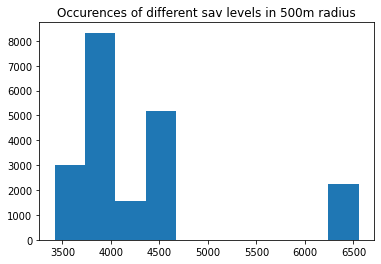

In [23]:
all_sav_data = []
for layer in raw_sav_data:
    for row in layer:
        for column in row:
            if column != 0:
                all_sav_data.append(column)
plt.hist(all_sav_data)
plt.title('Occurences of different sav levels in 500m radius')
plt.show()

In [11]:
size = 20

shrunk = []
for z in range(size, 1000, size):
    z_list = []
    for y in range(size, 1000, size):
        y_list = []
        for x in range(size, 1000, size):
            y_list.append(np.mean(raw_sav_data[:z, :y, :x]))
        z_list.append(y_list)
    shrunk.append(z_list)
    

In [3]:
import numpy as np

### SAV Layers
- heights and different layers of voxels confusing
- tall trees in area but barely go up to 1 meter before dissapearing
- most of the sav must be in understory/grass/litter at 1m
- most sav disapears at second layer
- goes up to 25 meters but is very little sav

Text(0.5, 1.0, 'Surface-area-to-volume(sav)')

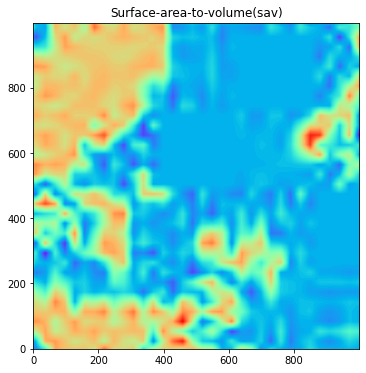

In [142]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(raw_sav_data[:,:,0], cmap='rainbow', origin="lower")
ax.set_title('Surface-area-to-volume(sav)')

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(raw_sav_data[:,:,1], cmap='rainbow', origin="lower")
ax.set_title('Surface-area-to-volume(sav) for Dixie Fire in in Lassen National Forest')

Text(0.5, 1.0, 'Surface-area-to-volume(sav)')

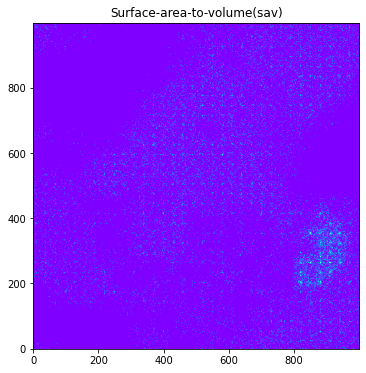

In [143]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(raw_sav_data[:,:,1], cmap='rainbow', origin="lower")
ax.set_title('Surface-area-to-volume(sav)')